## Notebook for NaI Array Calibration
Alya Sharbaugh, Anthony Villano, University of Colorado Denver

In [1]:
# Import libraries

import matplotlib.pyplot as plt
import numpy as np
import uproot
import os
import hist
from hist import Hist
from tabulate import tabulate
from lmfit.models import GaussianModel, LinearModel
from scipy.optimize import curve_fit


### Functions for Plots and Fits

In [12]:
# Define Gaussian distribution function

def Gauss(x, a, x0, sigma): 
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) 


In [3]:
# Define function for plotting histograms

def PlotHist(name,data,bins):

    fig, ax = plt.subplots(figsize=(8, 5))
    title = "Detector " + name[3:5]

    ax.plot(bins,data)
    
    ax.set_title(title)
    ax.set_xlabel("ADC Channel")
    ax.set_ylabel("PDF")
    ax.set_xlim([0,450])
    
    plt.show()
    

In [4]:
# Define function for fitting peaks to a Gaussian distrubution

def FitHist(data,center,bins,yint,amp):

    peak = GaussianModel()
    background = LinearModel()
    mod = peak + background

    counts, bin_edges = np.histogram(data,bins=bins)
    bin_widths = np.diff(bin_edges)
    x = bin_edges[:-1] + (bin_widths/2)
    y = counts
    
    pars = background.make_params(intercept=yint,slope=0)
    pars += peak.guess(y,x=x,center=center,amplitude=amp)
    final_fit = peak.fit(y,pars,x=x)
    #final_fit.plot_fit()
   
    center = final_fit.params['center'].value
    #center_err = final_fit.params['center'].stderr
    width = final_fit.params['fwhm'].value
    #width_err = final_fit.params['fwhm'].stderr

    return final_fit,bins,center,width


In [5]:
# Define function for plotting histograms with fit

def PlotFit(name,bins,data,bins1,fit1,bins2,fit2):

    fig, ax = plt.subplots(figsize=(8, 5))
    title = "Detector " + name[3:5]

    ax.plot(bins,data)
    ax.plot(bins1,fit1,'g--',label='Peak Fit')
    ax.plot(bins2,fit2,'r--',label='Peak Fit')

    ax.set_title(title)
    ax.set_xlabel("ADC Channel")
    ax.set_ylabel("PDF")
    ax.set_xlim([0,450])
    ax.legend(loc=1,prop={'size':12})
    
    plt.show()
    

### Background Calibration

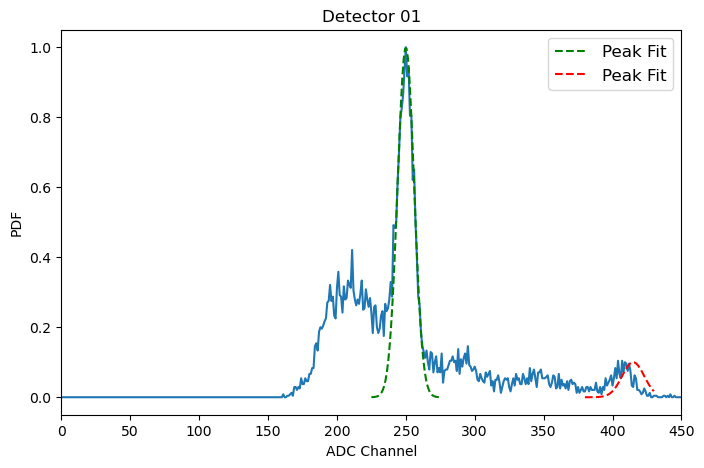

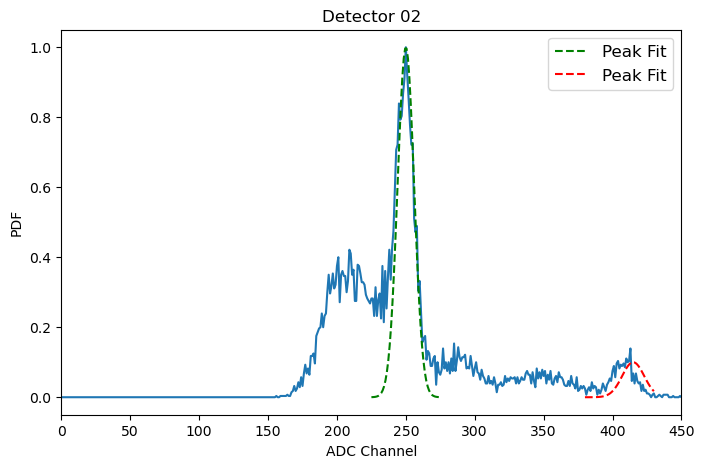

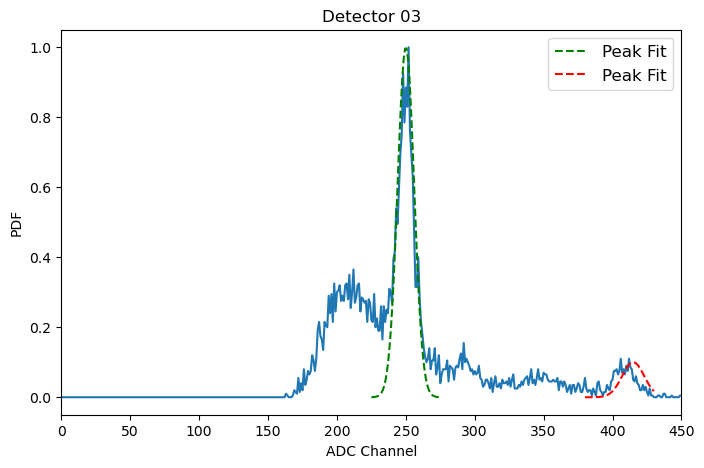

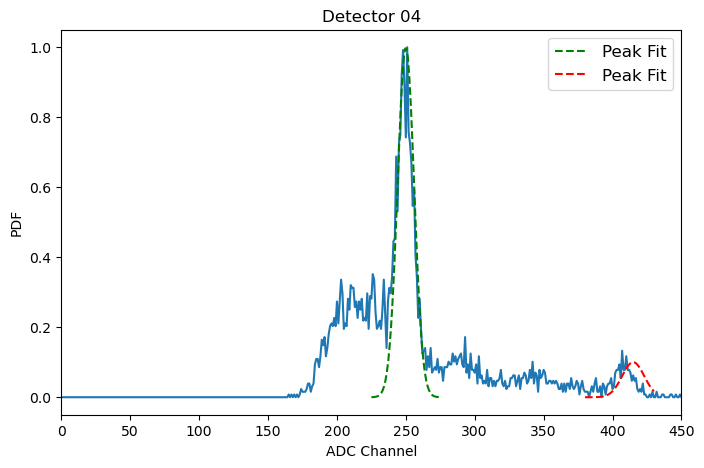

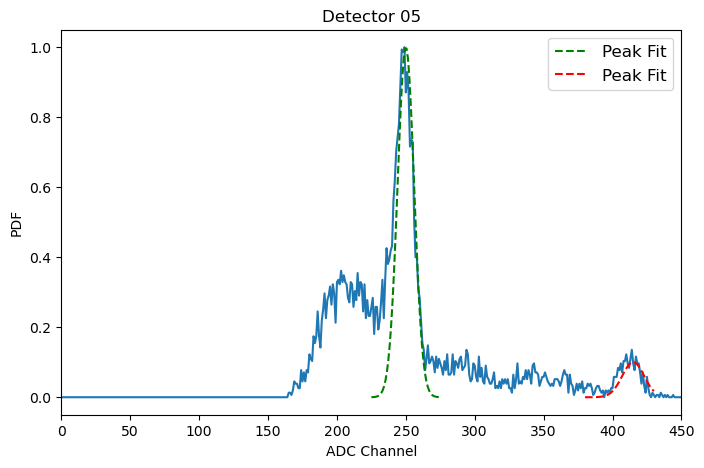

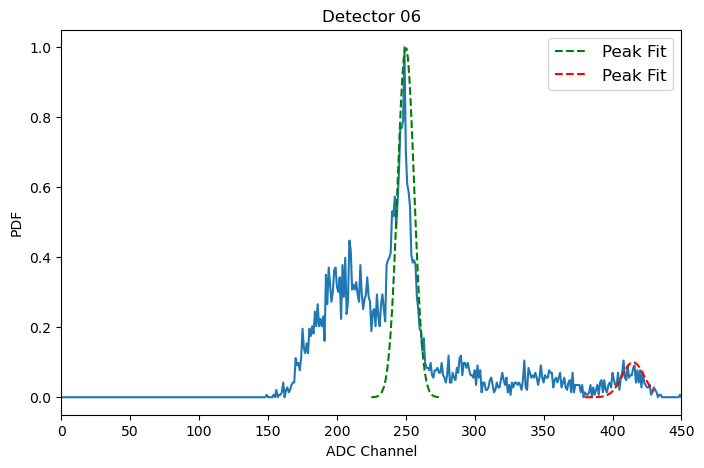

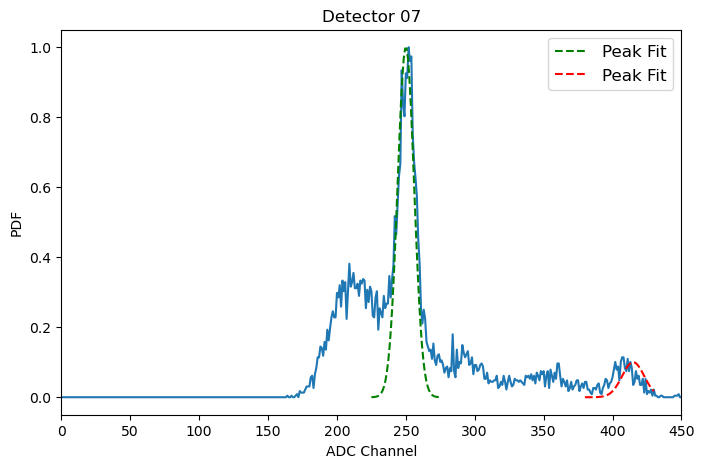

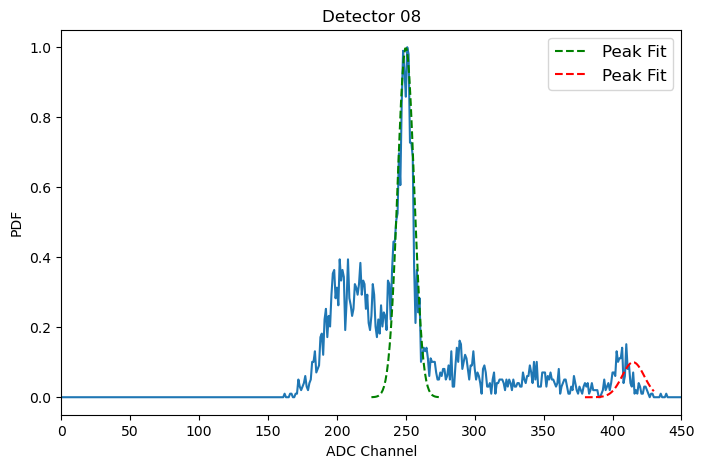

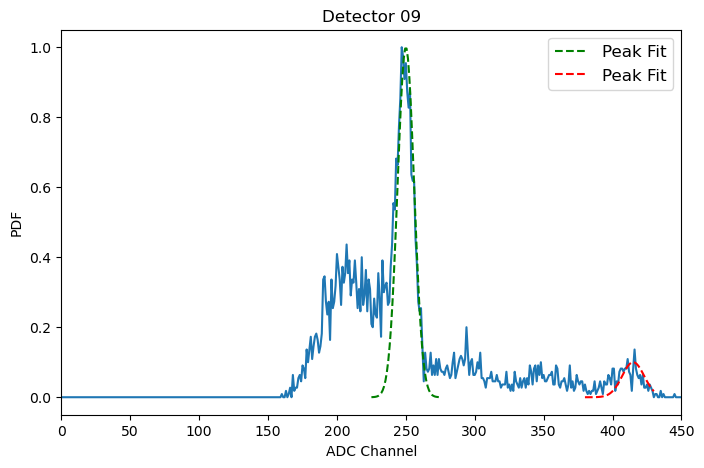

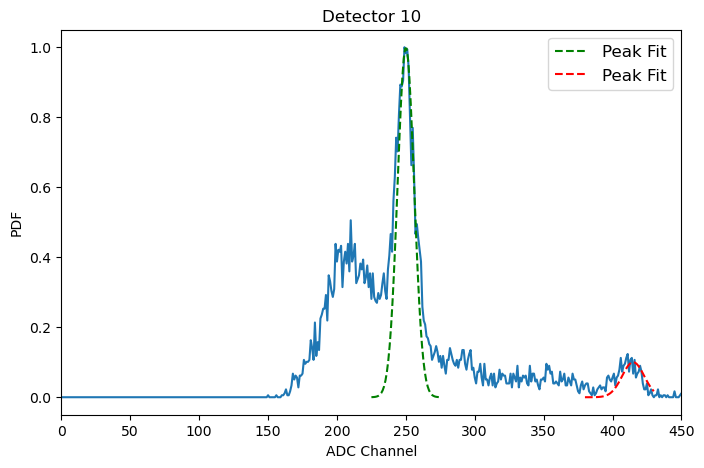

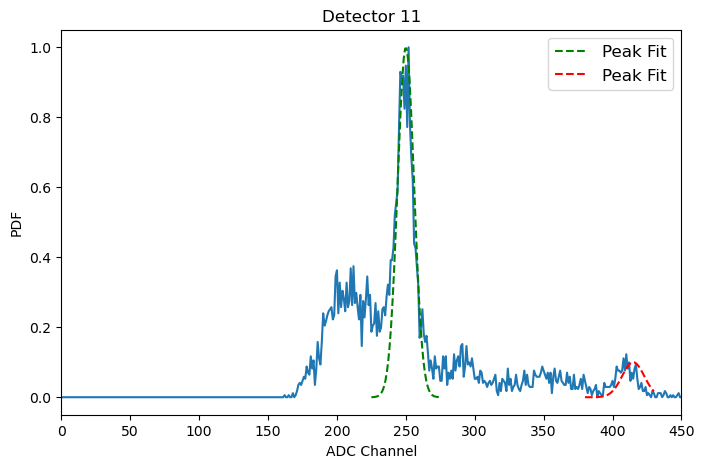

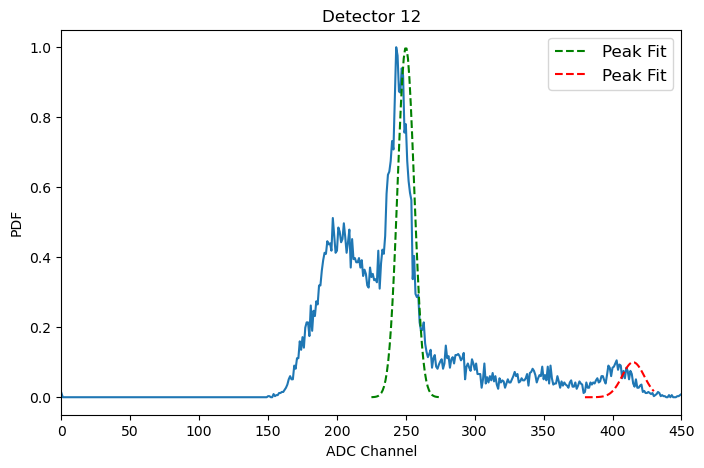

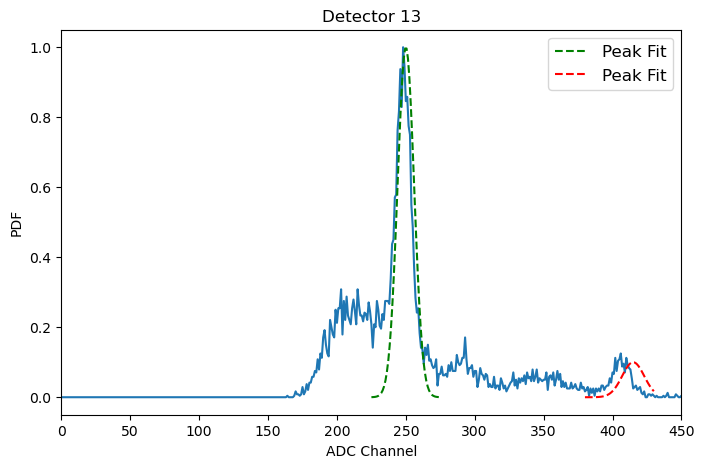

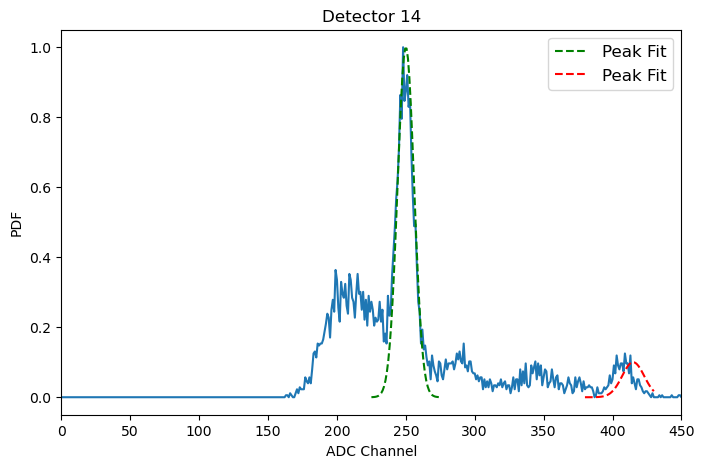

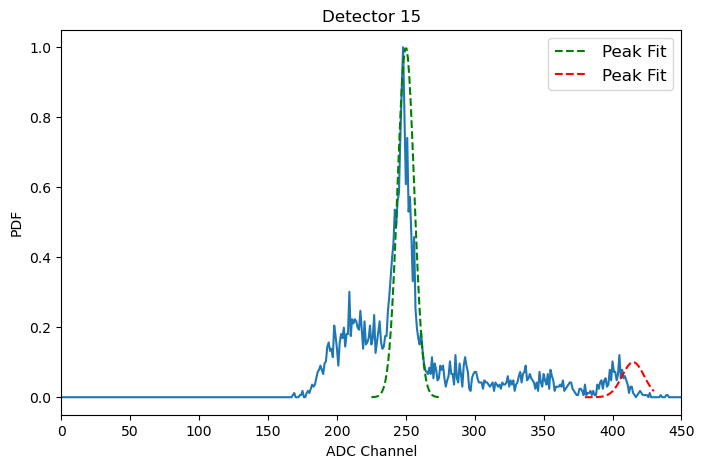

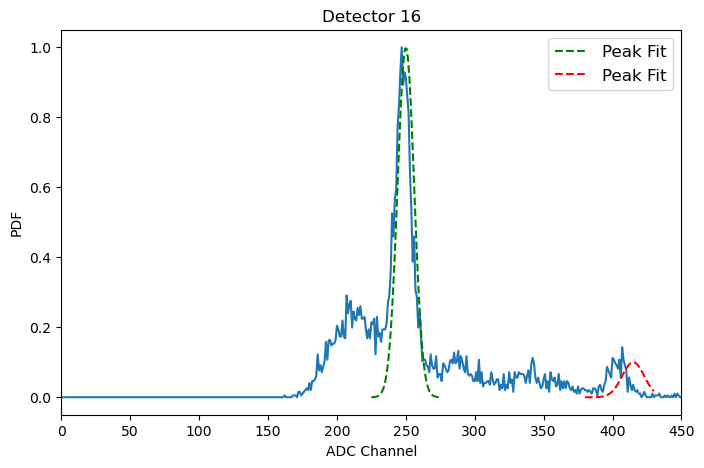

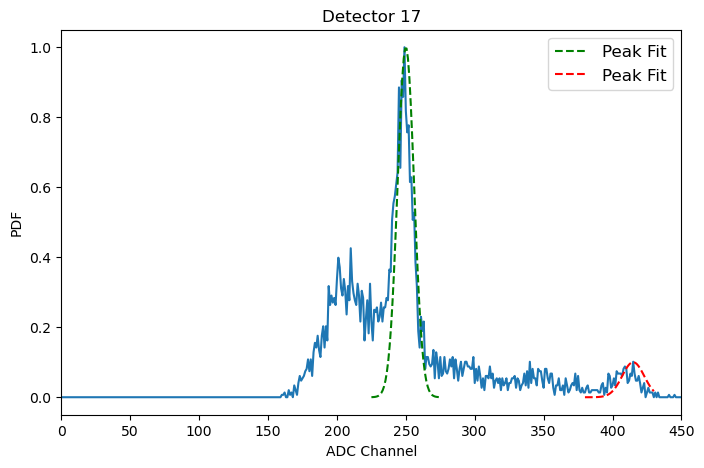

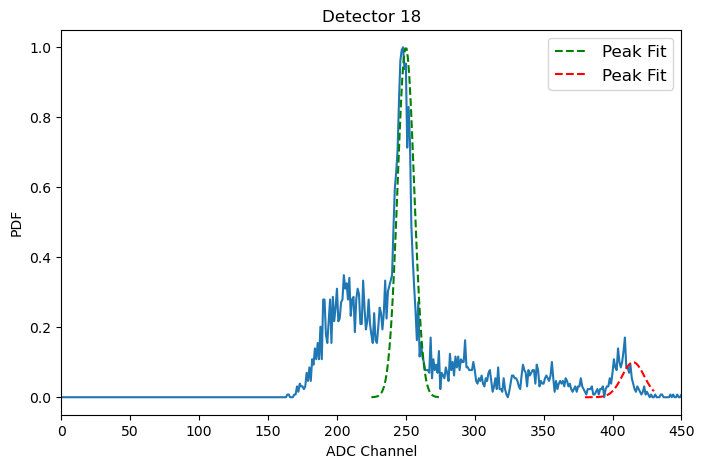

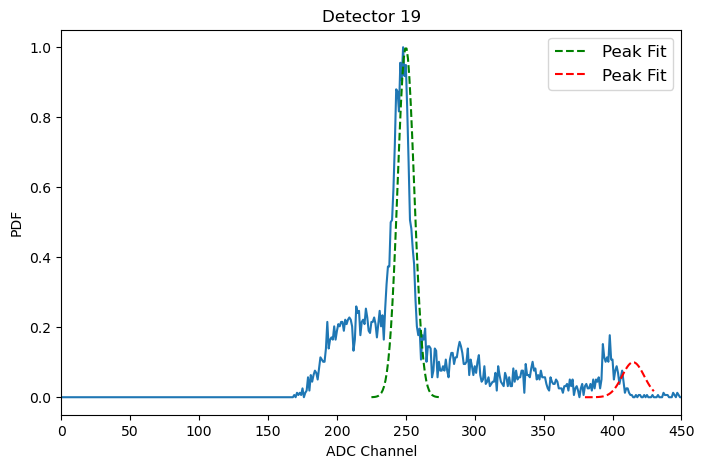

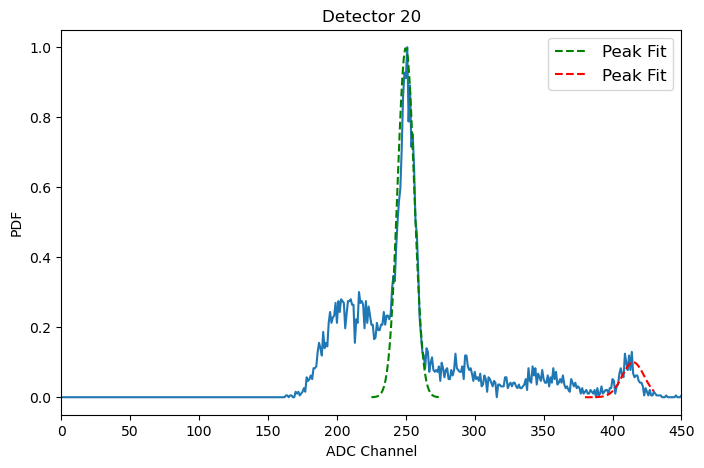

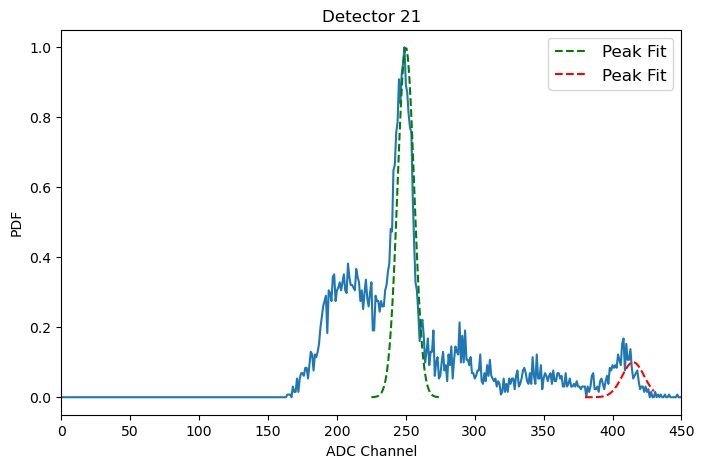

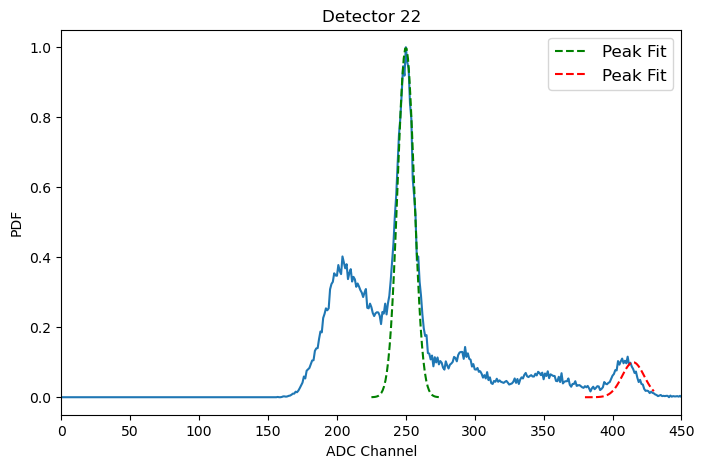

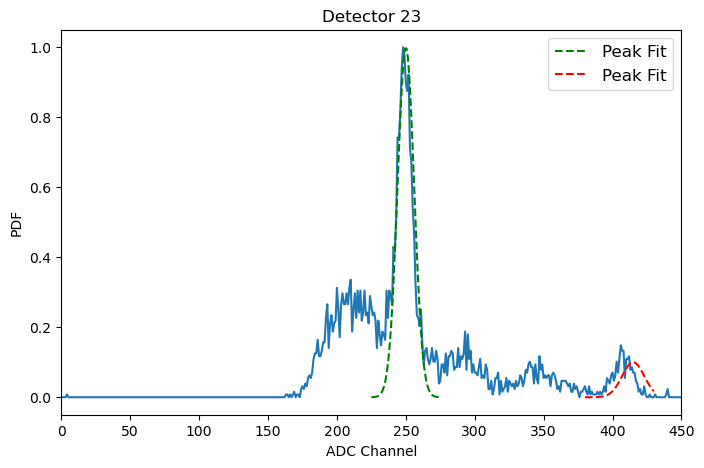

In [6]:
# Read in data from ROOT files and plot

directory = os.fsencode("Bknd_Calibration")
    
for file in os.listdir(directory):
    
    filename = os.fsdecode(file)
    datafile = "Bknd_Calibration/" + filename
    
    with uproot.open(datafile) as file:

        #print(file.keys())
        bknd = file["Energy/_F_EnergyCH0@DT5751_626"]
        bkndData,bins = bknd.to_numpy()

        bins = bins[:-1]   # Needed to trim bins to make arrays the same size, not sure why?
        
        bkndNorm = (bkndData - bkndData.min())/ (bkndData.max() - bkndData.min())   # Normalize since inconsistent counts

        #PlotHist(filename,bkndNorm,bins)

        bins1 = np.linspace(225,275,50)
        bins2 = np.linspace(380,430,50)

        fit1 = Gauss(bins1,1,250,6)   # Fit the channel 250 peak
        fit2 = Gauss(bins2,0.1,415,8)   # Fit the channel 400 peak

        PlotFit(filename,bins,bkndNorm,bins1,fit1,bins2,fit2)   # Plot normalized curve with fits
    

### Na-22 Calibration

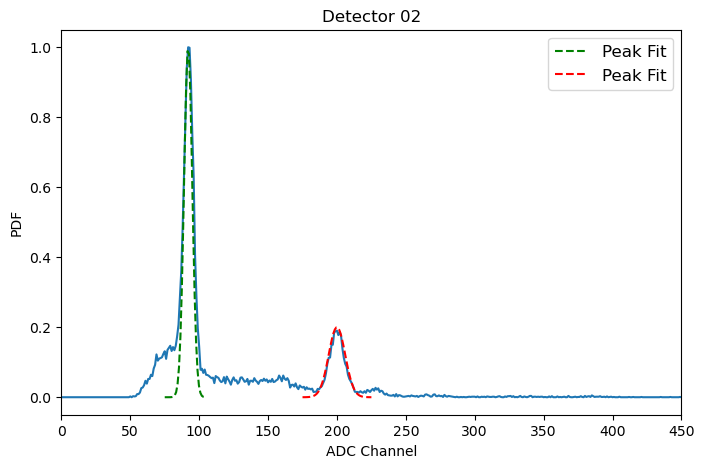

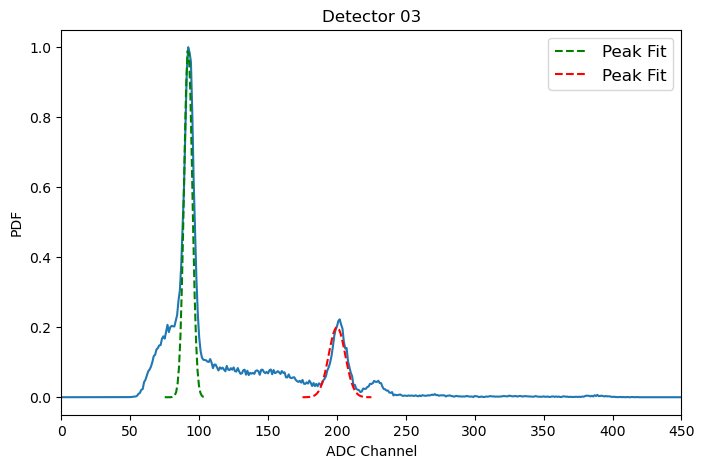

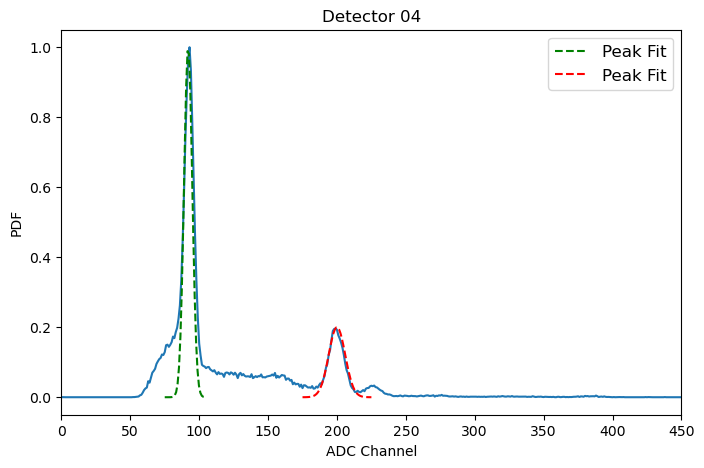

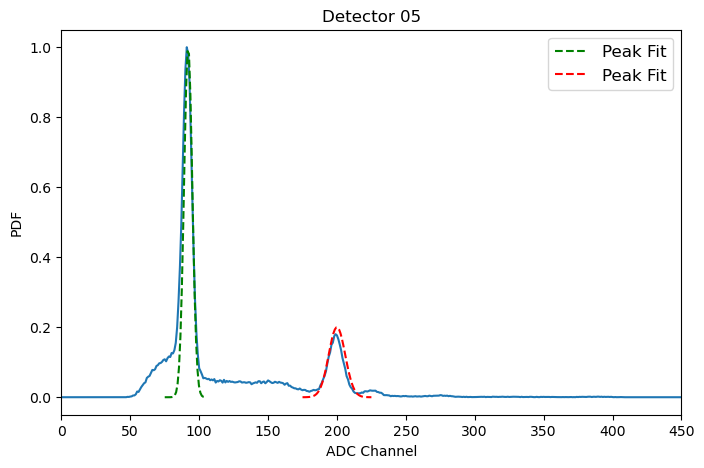

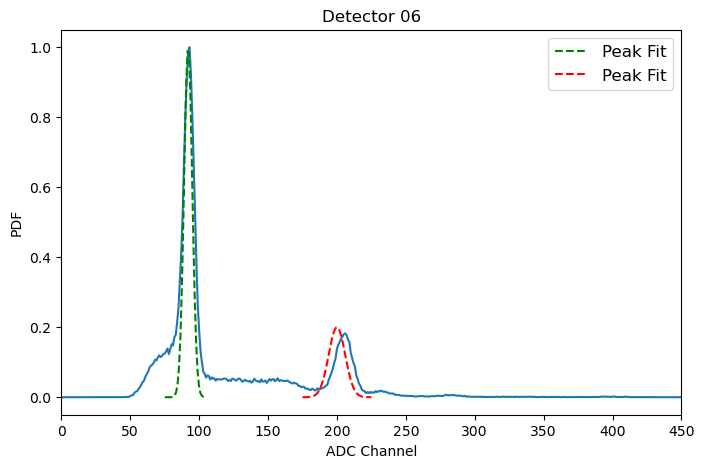

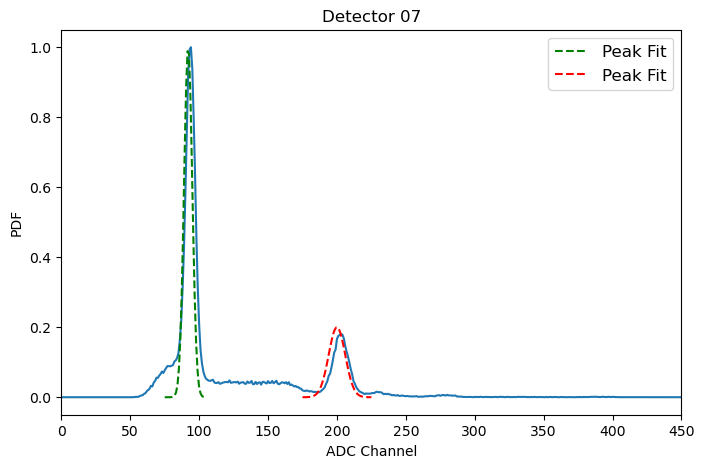

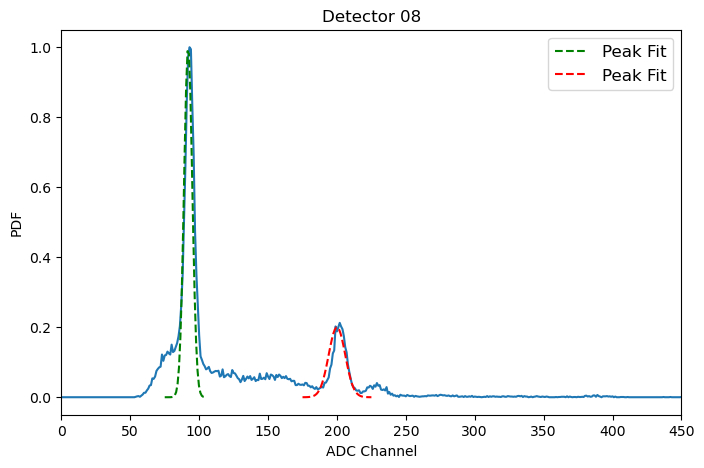

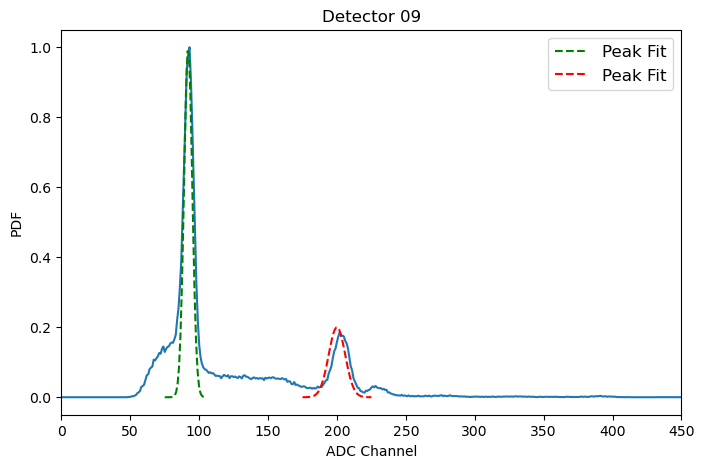

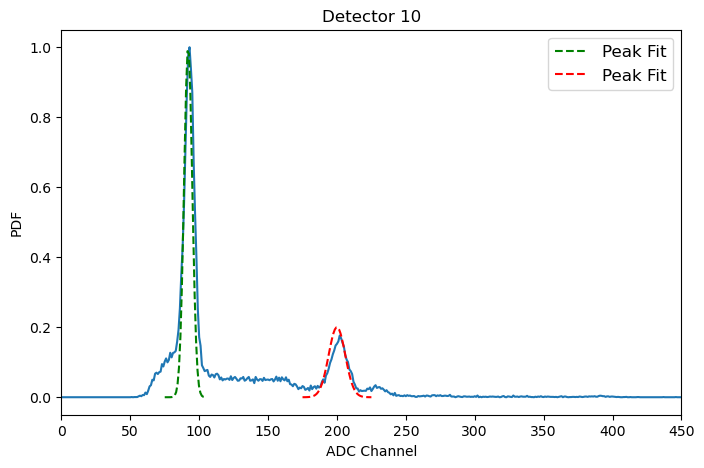

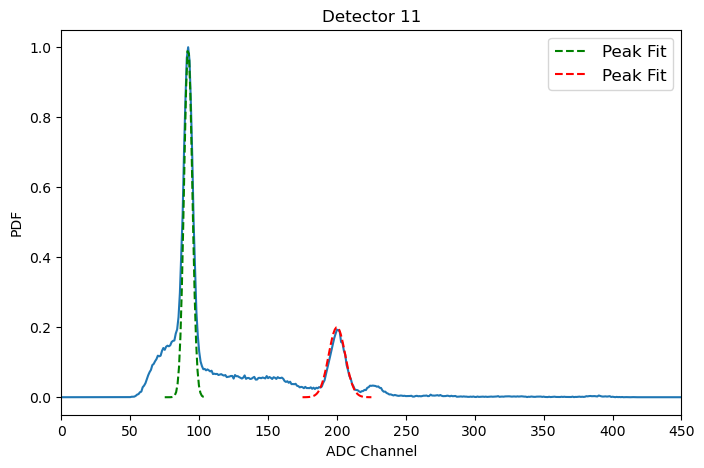

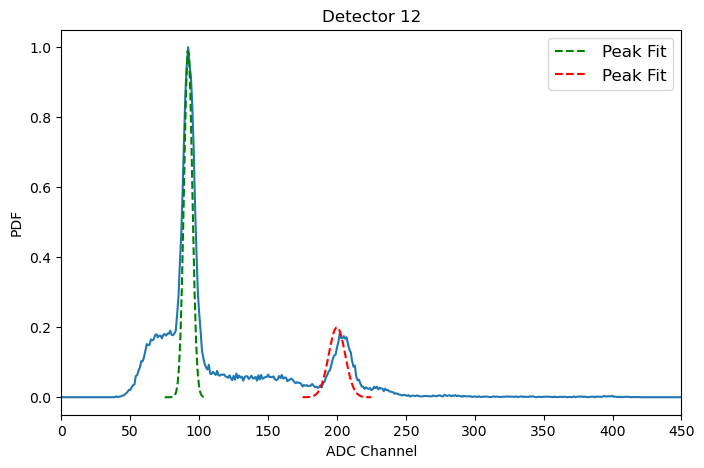

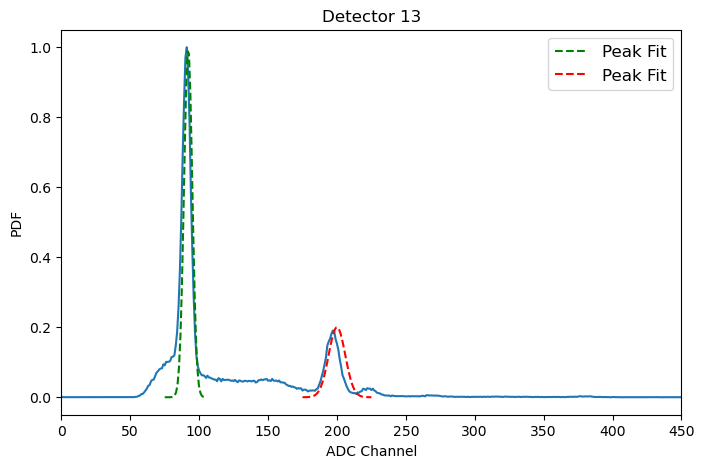

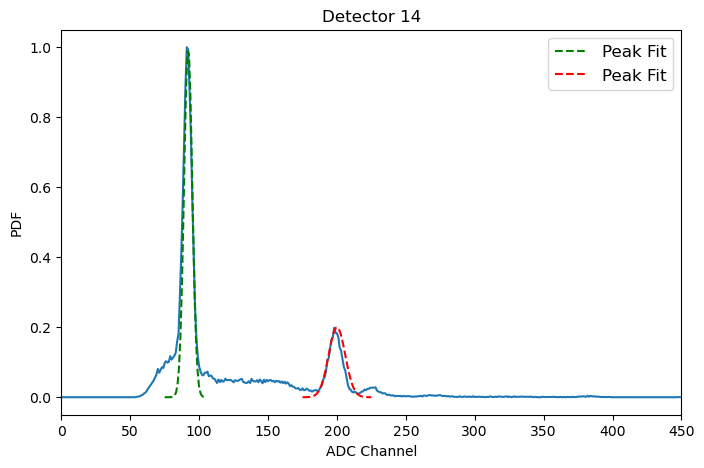

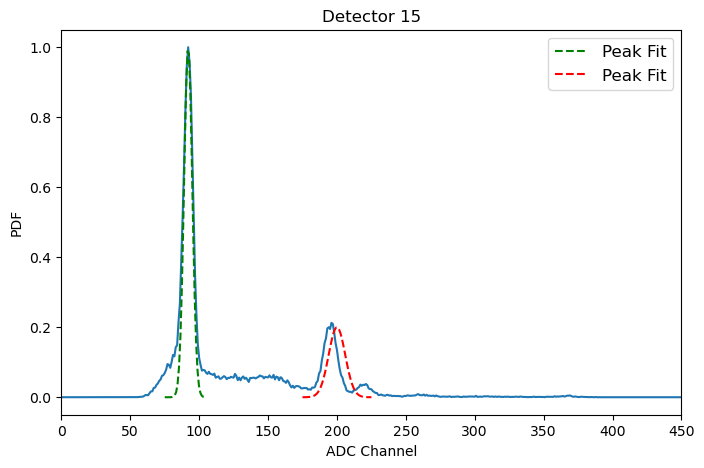

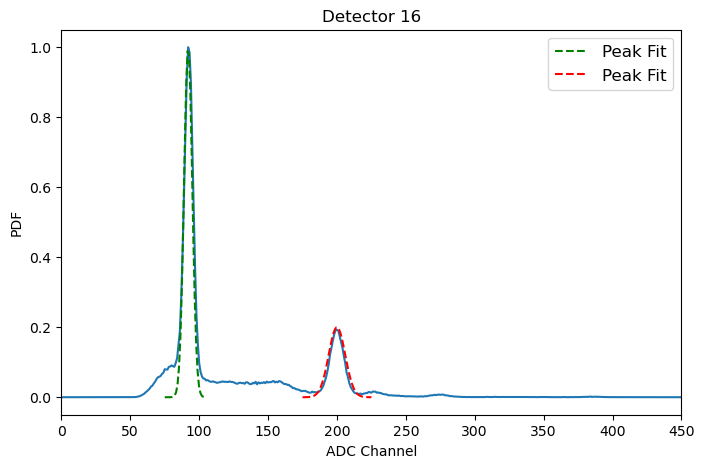

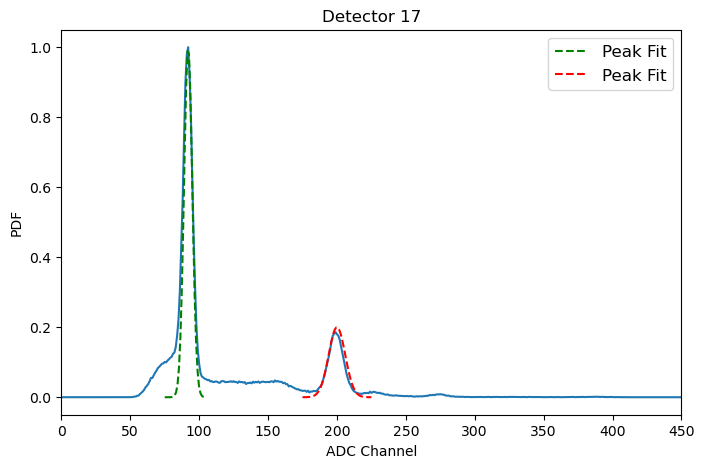

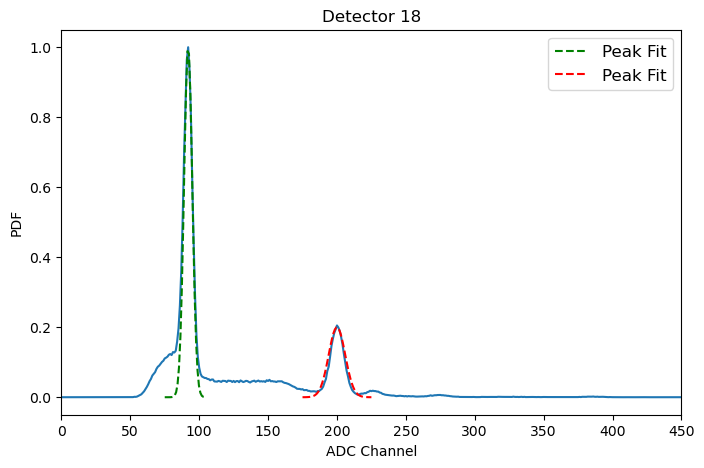

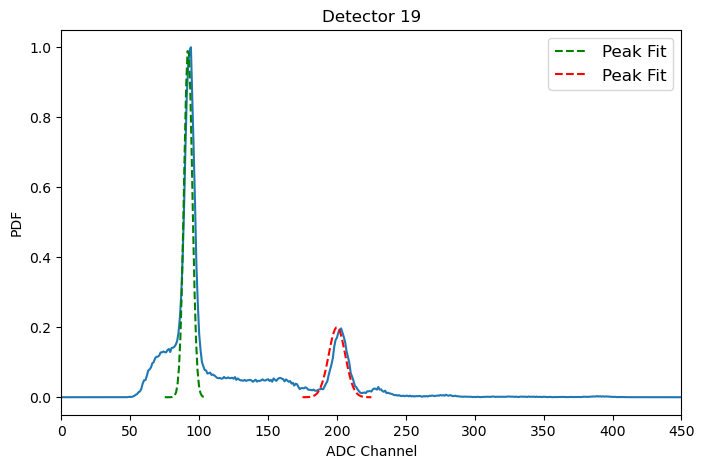

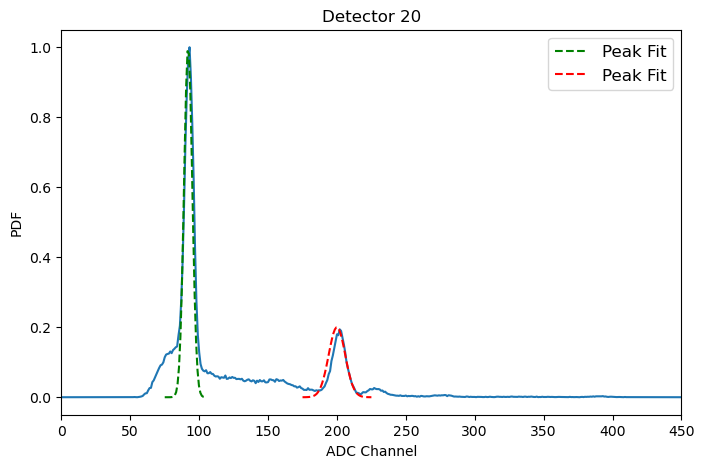

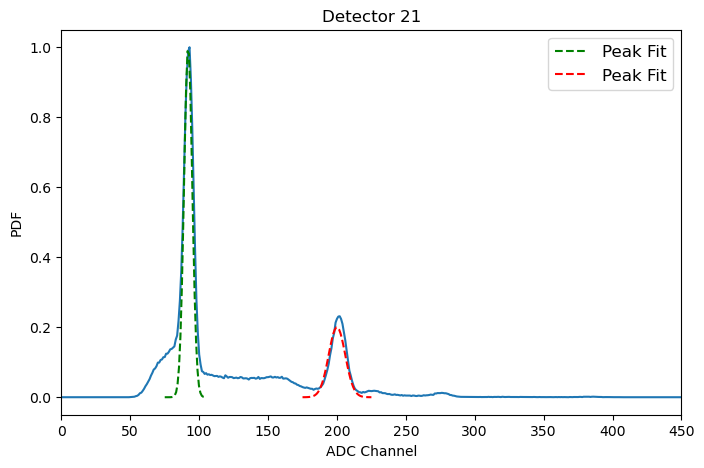

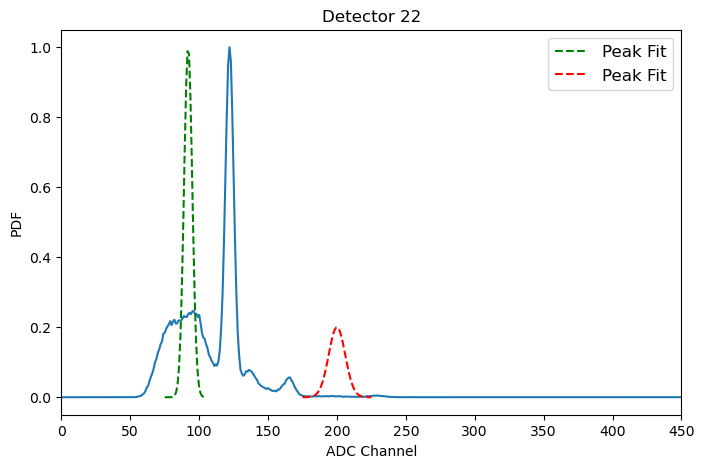

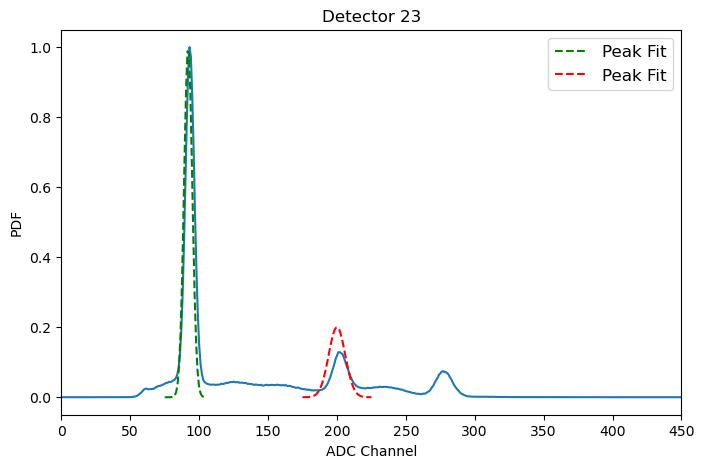

In [11]:
# Read in data from ROOT files and plot

directory = os.fsencode("Na22_Calibration")
    
for file in os.listdir(directory):
    
    filename = os.fsdecode(file)
    datafile = "Na22_Calibration/" + filename
    
    with uproot.open(datafile) as file:

        #print(file.keys())
        Na22 = file["Energy/_F_EnergyCH0@DT5751_626"]
        Na22Data,bins = Na22.to_numpy()

        bins = bins[:-1]   # Needed to trim bins to make arrays the same size, not sure why?
        
        Na22Norm = (Na22Data - Na22Data.min())/ (Na22Data.max() - Na22Data.min())   # Normalize since inconsistent counts
        
        #PlotHist(filename,Na22Norm,bins)

        bins1 = np.linspace(75,105,30)
        bins2 = np.linspace(175,225,50)

        fit1 = Gauss(bins1,1,92,3)   # Fit the channel 90 peak
        fit2 = Gauss(bins2,0.2,200,6)   # Fit the channel 200 peak

        PlotFit(filename,bins,Na22Norm,bins1,fit1,bins2,fit2)   # Plot normalized curve with fits
        